# Calculate and plot IBD square
1) Calculate pw. IBD pop dataframe  
2) Plot it as matrix plot  
@Author: Harald Ringbauer, 2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import h5py
import matplotlib.cm as cm
import itertools as it
import multiprocessing as mp
import matplotlib.patches as mpatches
from scipy.special import gammaincinv

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/yamnaya/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

#sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/python3/")  # hack to get development package first in path
from ancIBD.ibd_stats.funcs import new_columns, ibd_stats_pop_pairs, create_ibd_pop_pair_df, give_sub_df

compute-e-16-235.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/yamnaya
CPU Count: 28


In [2]:
def extract_sub_df_iids(df, iids, col="iid"):
    """Extract Sub Dataframe based on iids"""
    f1, f2 = col+"1", col+"2"
    idx = (dft[f1].isin(iids)) & (dft[f2].isin(iids))
    print(f"Found {np.sum(idx)} out of {len(df)} Pairs")
    return df[idx], df[~idx]

def load_full_ibd_pair_df(path_ibd="", path_iids=""):
    """Load the full pair IBD dataframe"""
    df = pd.read_csv(path_ibd, sep="\t")
    df_meta = pd.read_csv(path_iids, sep="\t")
    print(f"Loaded Meta information for {len(df_meta)} Individuals")
    print(f"Loaded pairs with IBD {len(df)} pairs")

    ### Merge in population list data
    iids = df_meta["iid"].values
    df_all = pd.DataFrame(list(it.combinations(iids,2))) # Only do diff. pairs
    df_all.columns = ["iid1", "iid2"]

    for col in df.columns[2:]:
        df_all[col] = 0

    ### Update the Info in Dataframe from 
    df = df.set_index(["iid1", "iid2"], drop=False)
    df_all = df_all.set_index(["iid1", "iid2"])
    df_all.update(df) # Write in Values
    ### Flip the Indices to get everything
    df = df.set_index(["iid2", "iid1"])
    df_all.update(df) # Write in Values
    
    df_all = df_all.reset_index() # Reset the index
    new_columns(df_all, df_meta, col = ["age", "study", "clst", "label_region"])
    print(f"Return information for {len(df_all)} pairs")
    k = np.sum(df_all["max_IBD"]>0)
    print(f"Set {k} IBD pairs>0 cM.")
    return df_all, df_meta

### Load the full IBD Dataframe

In [3]:
vrs = "54.1"

df, df_meta = load_full_ibd_pair_df(
   path_ibd=f"/n/groups/reich/hringbauer/git/yamnaya/output/ibd/v{vrs}/ibd_ind.d220.tsv",
   path_iids=f"/n/groups/reich/hringbauer/git/yamnaya/output/ibd/v{vrs}/iids_yam_v{vrs}.wgs.ibd.tsv") 
    
# Load the full IBD Dataframe
# 15675 pairs in v3, 
# 14398 IBD pairs with IBD euro dataset
# 51696 in v54.1

### Downsample to published Indivdiuals
idx1 = df["study1"].str.contains("Unpublished")
idx2 = df["study2"].str.contains("Unpublished")

df1 = df[~idx1 & ~idx2].copy()
print(f"Filtered to published IBD pairs: {np.sum(len(df1))}/{len(df)}")

idx = df_meta["study"].str.contains("Unpublished")
df_meta1 = df_meta[~idx].copy()
print(f"Samples that have been published: {np.sum(len(df_meta1))}/{len(df_meta)}")


Loaded Meta information for 862 Individuals
Loaded pairs with IBD 109352 pairs
Return information for 371091 pairs
Set 51696 IBD pairs>0 cM.
Filtered to published IBD pairs: 87153/371091
Samples that have been published: 418/862


In [ ]:
df1[df["iid1"].str.contains("VLI")].sort_values(by="sum_IBD>20", ascending=False)[:50]

In [43]:
df_meta1.to_csv(f"./data/tables/groups/published_v{vrs}.tsv", sep="\t", index=False)

# Create and save Population Pair IBD dataframe 
A dataframe with each entry being a pair of populations

In [31]:
%%time
### Takes about 30s for published data set
savepath = f"./output/ibd/tables/ibd_pop_pairs_v{vrs}.published.tsv"
cms = [8, 12, 16, 20, 0]
pops = set(df_meta1["label_region"])

#pops.remove("not assigned") # Drop the not assigned Values

pop_pairs = list(it.combinations_with_replacement(pops,2)) # Also do comparison with itself

fracs, cis, ns = ibd_stats_pop_pairs(df=df1, pop_pairs=pop_pairs, 
                            cms = cms, binary=True,
                            col = "label_region", a=0.32,
                            output=False, exact=True)
fracs, cis, ns = np.array(fracs), np.array(cis), np.array(ns)
pop_pairs = np.array(pop_pairs)

print("Saving the Population Pair IBD Statistic table...")
df_ibd = create_ibd_pop_pair_df(pop_pairs=pop_pairs, ns=ns, fracs=fracs, 
                                cis=cis, cms=cms, savepath=savepath)

Saving the Population Pair IBD Statistic table...
Saved 1485 pw. pop comparisons.
CPU times: user 29 s, sys: 0 ns, total: 29 s
Wall time: 29 s


# Plot IBD dataframe [standalone frome here]

In [4]:
def get_ibd_mat_ordered(df, pops, cm=[8,12]):
    """Get fst_mat and ste_mat in right order of pops.
    Return the two matrices with values filled in"""
    k=len(pops)
    combs = np.array(list(it.product(pops, repeat=2)))
    df_pairs = pd.DataFrame(combs)
    df_pairs.columns = ["s1", "s2"]
    
    ### Flip rows of f_st dataframe
    df1 = df.copy()
    df1["s2"], df1["s1"] = df["s1"], df["s2"]
    df1 = df1.drop(df1[df1["s2"]==df1["s1"]].index) # Remove the double counts
    df = df.append(df1).sort_index().reset_index(drop=True)
    df_merge = pd.merge(df_pairs, df, on=["s1", "s2"], how="left")
    
    ###
    n_mat = df_merge["n_pairs"].values.reshape((k,k))
    frac_mat = df_merge[f"{cm[0]}-{cm[1]}cm"].values.reshape((k,k))
    return frac_mat,n_mat
 

def plot_ibd_mat(pops, df, cm=[20,0], labels=[], figsize=(16,14), title="default", vrange=[], 
            fsl=10, fs_t=12, fs=14, cmap = "viridis", alpha=0.9,
            show=False, savepath="", reverse=False, show_frac=False): #fsl8
    """Create 2D colored plot of all combinations of pops.
    pops: Populations
    df: Pairwise IBD dataframe
    title: What to take as title.
    labels: The axis labels for the axis. (has to match pops in order)
    cm: Which IBDs to summarize and plot [2], in cM
    v_range: What range for the color values. If none, choose automatically
    fsl: Fontsize of data
    full: Whether to show the full Matrix
    show: Whether to plot the picture
    reverse: Whether to reverse color bar"""
    if title=="default":
        title = f"IBD Sharing {cm[0]}-{cm[1]} cM"

    k = len(pops)
    print("Nr. of populations: %i" % k)
    frac_mat, n_mat = get_ibd_mat_ordered(df=df, pops=pops, cm=cm)
        
    f = frac_mat.flatten()#.compressed() # So that list of entries for plotting values
    n = n_mat.flatten()#.compressed() # So that list of entries for plotting values
    cts = (f * n).astype("int") # Get counts of IBD blocks  
    #elif full==False:
    #    mask = np.logical_not(np.tri(k, k=-1)).T  # Mask out triangular matrix
    #    f_mat = np.ma.array(frac_mat, mask=mask)  # mask out the lower triangle
    
    ### Get the vrange
    if len(vrange)>0:
        vmin, vmax = vrange[0], vrange[1]
    else:
        vmin, vmax = np.min(frac_mat), np.max(frac_mat) # Do automatix scaling
    
    #### plot the figure
    plt.figure(figsize=figsize)
    ax=plt.gca()
    plt.axis("equal")
    if reverse == True:
        cmap = cmap + "_r"

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    c = plt.pcolor(frac_mat, vmin=vmin, vmax=vmax, alpha=alpha, cmap=cmap)  
    if len(labels)>0:
        plt.xticks(np.arange(k) + 0.5, labels, rotation=60, ha='right', fontsize=fs_t)
        plt.yticks(np.arange(k) + 0.5, labels, rotation='horizontal', fontsize=fs_t)
    
    def show_values(pc, show_frac=show_frac, fmt="%.2f"):    # Comment out %.3f \n" + r"$\pm$" + r"%.4f"
        pc.update_scalarmappable()
        #ax = pc.get_axes()
        for p, color, c0, n0 in zip(pc.get_paths(), pc.get_facecolors(), cts, n):  # pc.get_array()
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[1] > 0.5): ### Set the color depending on background
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)   
            label = f"{c0}/{n0}"
            if show_frac:
                label = label + f"\n{(100*c0/n0):.1f}%"
            ax.text(x, y, label, ha="center", va="center", color=color, fontsize=fsl)

    show_values(c, show_frac=show_frac, fmt = "%.2f")
    cb = plt.colorbar() # Do the colorbar
    cb.set_label('Fraction per pair of individuals', rotation=270, fontsize=fs, labelpad=fs)
    
    if len(title)>0:
        plt.title(title, fontsize=fs, pad=1)

    ax.set_xlim([0.0, k])
    ax.set_ylim([0.0, k])
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Figure saved to {savepath}")
    if show:
        plt.show()

In [13]:
df_meta[df_meta["label_region"].str.contains("Czech")]["label_region"].value_counts()

Czech_Unetice       85
Czech_BellBeaker    38
Czech_CordedWare    33
Czech_C             19
Czech_N              6
Czech_GAC            3
Czech_TRB            3
Czech_Rivnac         2
Czech_Jordanow       2
Czech_Baden          1
Name: label_region, dtype: int64

In [5]:
df_ibd = pd.read_csv(f"./output/ibd/tables/ibd_pop_pairs_v{vrs}.published.tsv", sep="\t")
#df_meta = pd.read_csv(f"/n/groups/reich/hringbauer/git/yamnaya/output/ibd/v{vrs}/iids_yam_v{vrs}.wgs.ibd.tsv", sep="\t")

pops_yamnaya = ['Ukraine_Yamnaya',
                'Russia_Kalmykia_Yamnaya', 'Russia_Samara_Yamnaya',
                 "Russia_Poltavka", "Russia_Afanasievo"]

pops_corded = ["Lithuania_LN", "Russia_Fatyanovo", 'Poland_CordedWare', 
               'Germany_CordedWare', 'Czech_CordedWare', 
               "Sweden_BAC",
               "Czech_Unetice", "Germany_BellBeaker", "Czech_BellBeaker"]  # Denmark_SGC

pops_gac = ['Romania_Bodrogkeresztur', 
            "Bulgaria_C", "Poland_TRB", "Hungary_Baden", 
            "Czech_Rivnac", "Czech_Jordanow", "Czech_C", # "Czech_Baden",
            "Czech_GAC", "Poland_GAC", "Ukraine_GAC"] # 
pops_kh = []
pops_ka = [] #"Russia_Maikop"

pops_sin = [] # ["Russia_Sintashta", "Russia_Andronovo"]

pops_all = pops_yamnaya + pops_corded + pops_kh + pops_gac + pops_ka + pops_sin


dct_n = dict(df_meta1["label_region"].value_counts()) # Dictionary for population Counts
ns = list(map(dct_n.get, pops_all))

labels =[p.replace("_"," ") + f" ({ns[i]})" for i,p in enumerate(pops_all)]

### Save Indivdiuals in Analysis

In [17]:
savepath = "../hapBLOCK/output/tables/published_ibd_mat_iids.tsv"

dft = df_meta1[df_meta1["label_region"].isin(pops_all)].copy()
dft.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(dft)} IIDs to {savepath}")

Saved 304 IIDs to ../hapBLOCK/output/tables/published_ibd_mat_iids.tsv


In [21]:
len(dft["label_region"].value_counts())

24

Nr. of populations: 24
Figure saved to ./figs/ibd_mat/v54.1/pub.ibd_mat>20cm.pdf


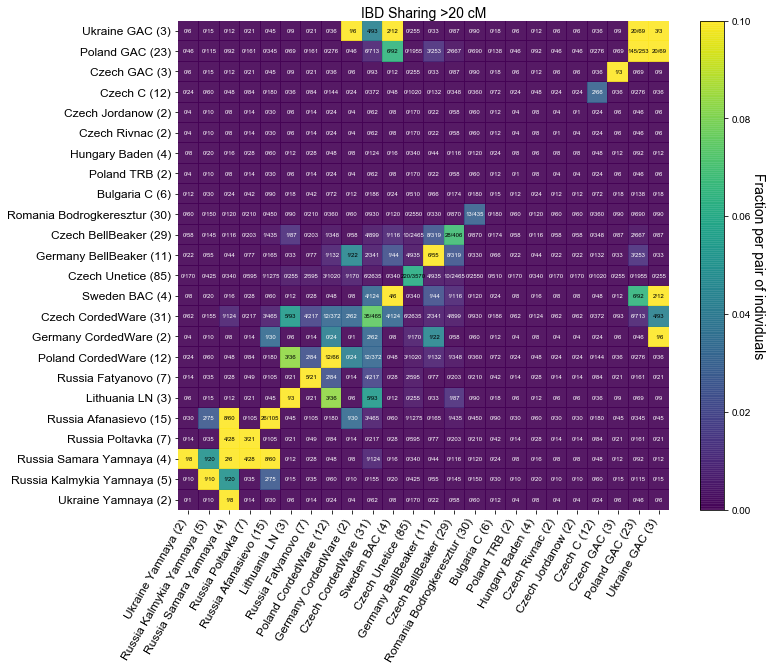

In [35]:
plot_ibd_mat(pops_all, df_ibd, figsize=(11, 9), labels=labels, 
             title="IBD Sharing >20 cM", savepath=f"./figs/ibd_mat/v{vrs}/pub.ibd_mat>20cm.pdf", # .f"./figs/ibd_mat/v{vrs}/ibd_mat>20cm.pdf"
             cm=[20, 0], vrange=[0,0.1], show_frac=False, fsl=6)

Nr. of populations: 24
Figure saved to ./figs/ibd_mat/v54.1/pub.ibd_mat_16-20cm.pdf


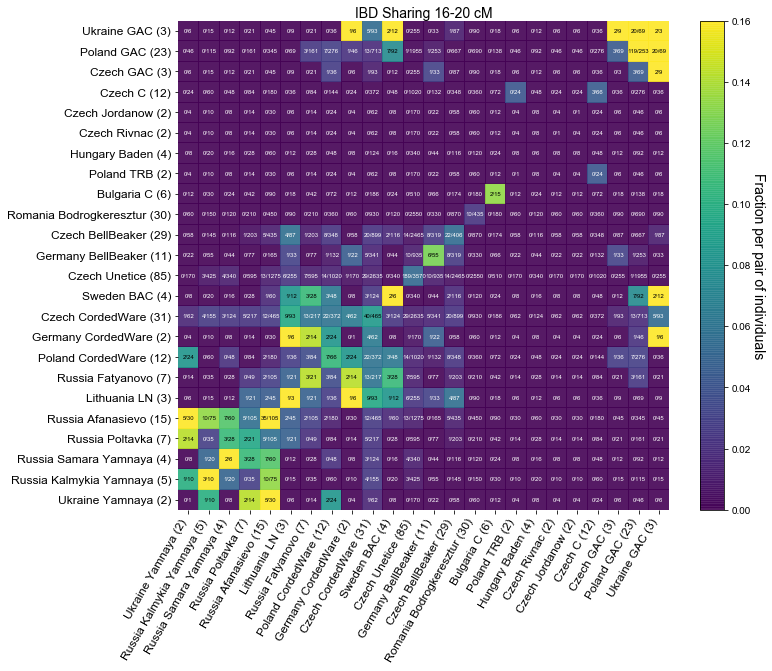

In [39]:
plot_ibd_mat(pops_all, df_ibd, figsize=(11, 9), labels=labels, title="default", 
             savepath=f"./figs/ibd_mat/v{vrs}/pub.ibd_mat_16-20cm.pdf", #.
             cm=[16, 20], vrange=[0,0.16], show_frac=False, fsl=6) 

Nr. of populations: 24
Figure saved to ./figs/ibd_mat/v54.1/pub.ibd_mat_12-16cm.pdf


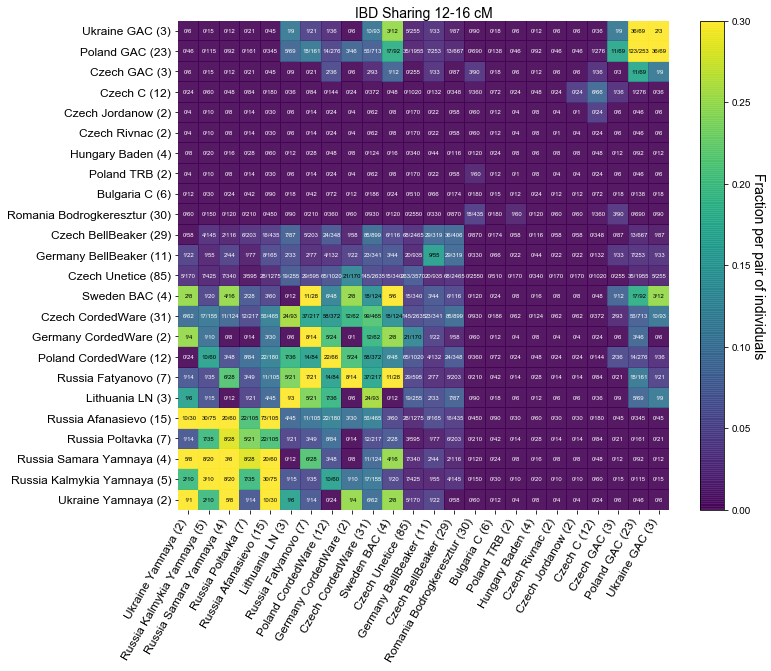

In [37]:
plot_ibd_mat(pops_all, df_ibd, figsize=(11, 9), labels=labels, title="default", 
             savepath=f"./figs/ibd_mat/v{vrs}/pub.ibd_mat_12-16cm.pdf", #./figs/ibd_mat/ibd_mat_12-16cm.pdf
             cm=[12, 16], vrange=[0,0.3], show_frac=False, fsl=6) 

Nr. of populations: 24
Figure saved to ./figs/ibd_mat/v54.1/pub.ibd_mat_8-12cm.pdf


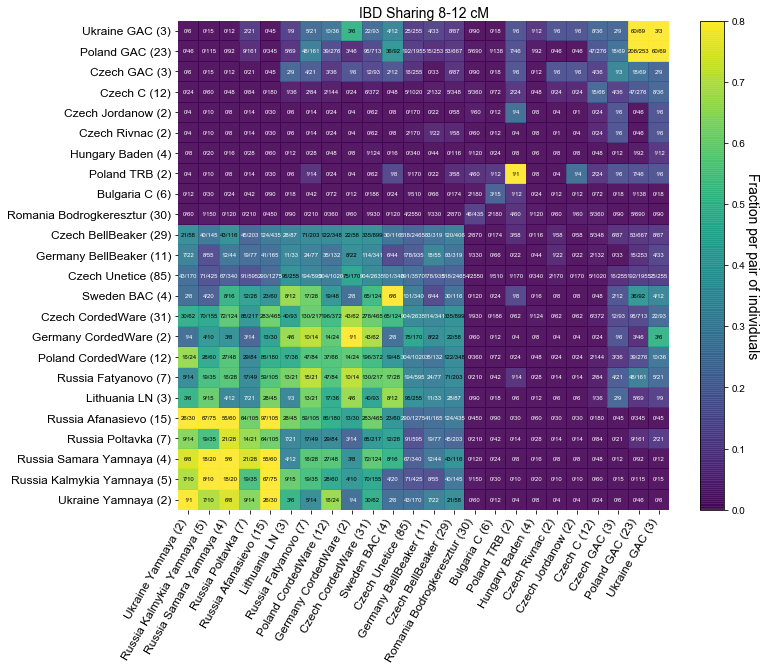

In [38]:
plot_ibd_mat(pops_all, df_ibd, figsize=(11, 9),
             labels=labels, title="default", savepath=f"./figs/ibd_mat/v{vrs}/pub.ibd_mat_8-12cm.pdf", 
             cm=[8, 12], vrange=[0,0.8], show_frac=False, fsl=6) # ./figs/ibd_mat/ibd_mat_8-12cm.pdf

# Area 51

In [ ]:
df_meta1["study"].value_counts()